# 查看FashionMNIST原始数据格式

In [15]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 加载数据并处理为tensor

In [16]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称
class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")



训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [17]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [18]:
64*860

55040

# 搭建模型

In [19]:
from torch import nn
# 实现深度可分离卷积层
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        # 深度卷积 - 每个输入通道使用单独的卷积核
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels  # 将输入通道分组，每组一个通道
        )
        # 逐点卷积 - 使用1x1卷积进行通道混合
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# 测试深度可分离卷积层
input_tensor = torch.randn(1, 3, 28, 28)  # 批次大小为1，3个输入通道，28x28图像
separable_conv = DepthwiseSeparableConv(in_channels=3, out_channels=16, kernel_size=3, padding=1)
output = separable_conv(input_tensor)
print(f"输入形状: {input_tensor.shape}")
print(f"输出形状: {output.shape}")
print(f"参数数量: {sum(p.numel() for p in separable_conv.parameters())}")


输入形状: torch.Size([1, 3, 28, 28])
输出形状: torch.Size([1, 16, 28, 28])
参数数量: 94


In [35]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        # 设置激活函数
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'selu':
            self.activation = F.selu
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        
        # 第一组卷积层 - 32个卷积核
        self.conv1 = DepthwiseSeparableConv(1, 32, kernel_size=3, padding=1)
        self.conv2 = DepthwiseSeparableConv(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二组卷积层 - 64个卷积核
        self.conv3 = DepthwiseSeparableConv(32, 64, kernel_size=3, padding=1)
        self.conv4 = DepthwiseSeparableConv(64, 64, kernel_size=3, padding=1)
        
        # 第三组卷积层 - 128个卷积核
        self.conv5 = DepthwiseSeparableConv(64, 128, kernel_size=3, padding=1)
        self.conv6 = DepthwiseSeparableConv(128, 128, kernel_size=3, padding=1)
        
        # 第四组卷积层 - 256个卷积核
        self.conv7 = DepthwiseSeparableConv(128, 256, kernel_size=3, padding=1)
        self.conv8 = DepthwiseSeparableConv(256, 256, kernel_size=3, padding=1)
        
        # 计算全连接层的输入特征数
        # 经过4次池化，图像尺寸从28x28变为1x1x256
        self.fc1 = nn.Linear(256 * 1 * 1, 512)  # 修正输入特征数为256
        self.fc2 = nn.Linear(512, 10)
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 Lecun Normal 分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        
        # 第一组卷积层
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        
        # 第二组卷积层
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.pool(x)
        
        # 第三组卷积层
        x = self.activation(self.conv5(x))
        x = self.activation(self.conv6(x))
        x = self.pool(x)
        
        # 第四组卷积层
        x = self.activation(self.conv7(x))
        x = self.activation(self.conv8(x))
        x = self.pool(x)
        
        # 展平
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        # print(f"fc2后的形状: {x.shape}")
        
        return x


In [36]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    

print(outputs.shape)


批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [37]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 274804
模型总参数量: 274804

各层参数量明细:
conv1.depthwise.weight: 9 参数
conv1.depthwise.bias: 1 参数
conv1.pointwise.weight: 32 参数
conv1.pointwise.bias: 32 参数
conv2.depthwise.weight: 288 参数
conv2.depthwise.bias: 32 参数
conv2.pointwise.weight: 1024 参数
conv2.pointwise.bias: 32 参数
conv3.depthwise.weight: 288 参数
conv3.depthwise.bias: 32 参数
conv3.pointwise.weight: 2048 参数
conv3.pointwise.bias: 64 参数
conv4.depthwise.weight: 576 参数
conv4.depthwise.bias: 64 参数
conv4.pointwise.weight: 4096 参数
conv4.pointwise.bias: 64 参数
conv5.depthwise.weight: 576 参数
conv5.depthwise.bias: 64 参数
conv5.pointwise.weight: 8192 参数
conv5.pointwise.bias: 128 参数
conv6.depthwise.weight: 1152 参数
conv6.depthwise.bias: 128 参数
conv6.pointwise.weight: 16384 参数
conv6.pointwise.bias: 128 参数
conv7.depthwise.weight: 1152 参数
conv7.depthwise.bias: 128 参数
conv7.pointwise.weight: 32768 参数
conv7.pointwise.bias: 256 参数
conv8.depthwise.weight: 2304 参数
conv8.depthwise.bias: 256 参数
conv8.pointwise.weight: 65536 参数
conv8.pointwise.bias: 256

# 设置交叉熵损失函数，SGD优化器

In [38]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [39]:
model = NeuralNetwork('selu')

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=10, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cpu
训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 绘制损失曲线和准确率曲线

In [ ]:
# 导入绘图库
import matplotlib.pyplot as plt
from matplotlib import font_manager
def plot_learning_curves1(history):
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    # 创建一个图形，包含两个子图（损失和准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    ax1.set_title('训练与验证损失')
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.legend()
    ax1.grid(True)

    # 绘制准确率曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
    ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
    ax2.set_title('训练与验证准确率')
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率 (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


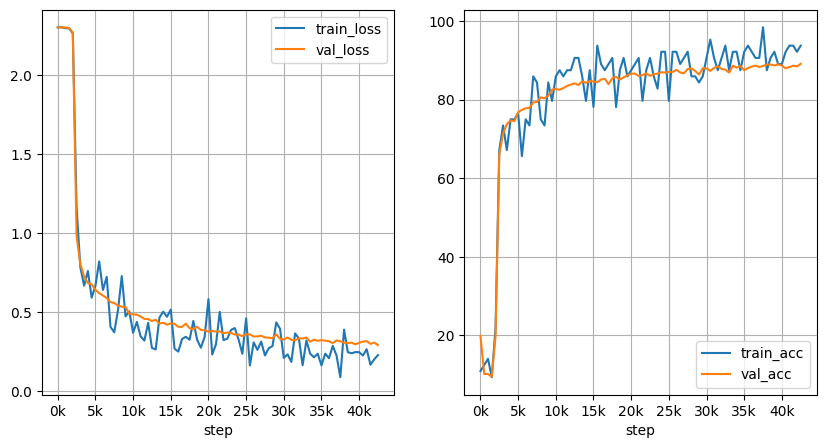

In [ ]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [ ]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(89.17, 0.3090566464781761)